## Exercise 1: Support Vector Machines

In [1]:
import numpy as np
import cv2
import glob
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import os

def create_keypoints(w, h):
    keypoints = []
    keypointSize = 11
    # please sample the image uniformly in a grid
    # find the keypoint size and number of sample points
    # as hyperparameters
    grid_size=16

    for r in range(0,h,grid_size):
        for c in range(0,w,grid_size):
            ## the region around each keypoint for feature extraction.
            ## Keypoint size is the diameter of the region around each keypoint for feature extraction.
            keypoints.append(cv2.KeyPoint(float(c),float(r),size=keypointSize))

    return keypoints

def prepareData(image_path,labels=None):
    X=[]
    y=[]
    sift=cv2.SIFT_create()
    for index,path in enumerate(image_path):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        width,height=img.shape
        keypoints=create_keypoints(width,height)
        _,descriptors=sift.compute(img,keypoints)
        if descriptors is not None:
            X.append(descriptors.flatten())
            if labels is not None:
                y.append(labels[index])
    X=np.array(X)
    y=np.array(y) if labels is not None else None
    return X,y

# Load training images
train_paths = glob.glob('./images/db/train/**/*.jpg', recursive=True)
train_labels = [os.path.basename(os.path.dirname(p)) for p in train_paths]

## Encde labels to integer
label_encoder = LabelEncoder()
## encode the y train from labels to numeric
y_train = label_encoder.fit_transform(train_labels)
print('y train',y_train)

x_train,y_train=prepareData(train_paths,y_train)

# Train SVM classifier with different kernels
kernels = ['linear', 'poly', 'rbf']
best_model=None
best_accuracy=0
for kernel in kernels:
    clf=svm.SVC(kernel=kernel)
    clf.fit(x_train,y_train)
    ## test classifier on training sets
    y_pred_train=clf.predict(x_train)
    accuracy = accuracy_score(y_train, y_pred_train)
    print(f"Kernel: {kernel}, Training Accuracy: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clf

## load amd classify test images
test_paths=glob.glob('./images/db/test/*.jpg', recursive=True)
# Extract test labels directly from filenames
test_labels = [os.path.splitext(os.path.basename(p))[0] for p in test_paths]
print(label_encoder.classes_)
# Example label mapping
label_mapping = {
    'flower2': 'flowers',
    'flower': 'flowers',
    'face': 'faces',
    'car': 'cars',
}

test_labels_mapped = [label_mapping.get(label, None) for label in test_labels]

y_test = label_encoder.transform(test_labels_mapped)
print('y test',y_test)

X_test, _ = prepareData(test_paths)

# Predict and evaluate
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Output predictions with labels
for i, path in enumerate(test_paths):
    print(f"Image: {path}, Predicted Label: {label_encoder.inverse_transform([y_pred[i]])[0]}")

y train [2 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Kernel: linear, Training Accuracy: 1.0
Kernel: poly, Training Accuracy: 1.0
Kernel: rbf, Training Accuracy: 1.0
['cars' 'faces' 'flowers']
y test [2 1 0 2]
Test Accuracy: 1.0
Image: ./images/db/test/flower2.jpg, Predicted Label: flowers
Image: ./images/db/test/face.jpg, Predicted Label: faces
Image: ./images/db/test/car.jpg, Predicted Label: cars
Image: ./images/db/test/flower.jpg, Predicted Label: flowers


## Exercise 2: Implement your own neural network from scratch 

0 ./images/db/train/cars/2539497709_756f025f62.jpg
0 ./images/db/train/cars/2847324790_6dd07ffb54.jpg
0 ./images/db/train/cars/1137646735_2fb2752249.jpg
0 ./images/db/train/cars/car001.jpg
0 ./images/db/train/cars/car003.jpg
0 ./images/db/train/cars/car002.jpg
1 ./images/db/train/flowers/astra04.jpg
1 ./images/db/train/flowers/3826419553_c00dc0e91c.jpg
1 ./images/db/train/flowers/2682530432_e470494b40.jpg
1 ./images/db/train/flowers/0106476_1.jpg
1 ./images/db/train/flowers/marcinki.jpg
1 ./images/db/train/flowers/ANBL.jpg
2 ./images/db/train/faces/3573927657_df093bae27.jpg
2 ./images/db/train/faces/397642272_cedf622248_z.jpg
2 ./images/db/train/faces/61060671.jpg
2 ./images/db/train/faces/face.jpg
2 ./images/db/train/faces/img_1577_crazy-face.jpg
2 ./images/db/train/faces/face2.jpg
2 ./images/db/train/faces/images.jpg
2 ./images/db/train/faces/3775982780_d5ea306ce6.jpg
Epoch 0/500, Loss: 1.0494
Epoch 10/500, Loss: 0.8879
Epoch 20/500, Loss: 0.9878
Epoch 30/500, Loss: 0.7559
Epoch 40/5

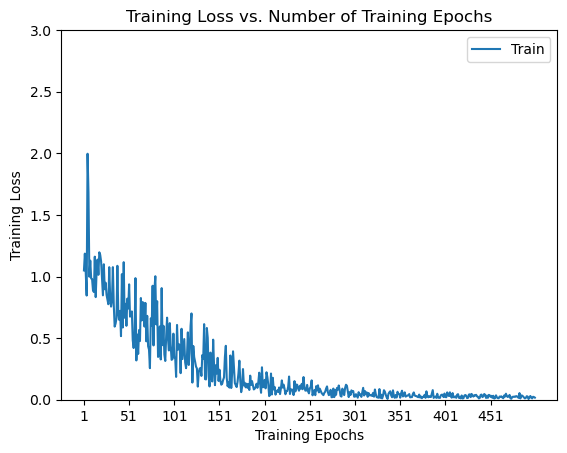

In [15]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# set a fixed seed for reproducability
np.random.seed(0)

nn_img_size = 32
num_classes = 3 ## flowers, cars faces
learning_rate = 0.0001
num_epochs = 500
batch_size = 4

loss_mode = 'crossentropy'

loss_train_hist = []

##################################################
## Please implement a two layer neural network  ##
##################################################


def relu(x):
    """ReLU activation function"""
    return np.maximum(x, 0)


def relu_derivative(output):
    """derivative of the ReLU activation function"""
    output[output <= 0] = 0
    output[output > 0] = 1
    return output


def softmax(z):
    """softmax function to transform values to probabilities"""
    z -= z.max()
    z = np.exp(z)
    sum_z = z.sum(1, keepdims=True)
    return z / sum_z


def loss_mse(activation, y_batch):
    """mean squared loss function"""
    # use MSE error as loss function
    # Hint: the computed error needs to get normalized over the number of samples
    loss = ((activation - y_batch)**2).sum()
    mse = 1.0 / activation.shape[0] * loss
    return mse


def loss_crossentropy(activation, y_batch):
    """cross entropy loss function"""
    batch_size = y_batch.shape[0]
    loss = (-y_batch * np.log(activation)).sum() / batch_size
    return loss


def loss_deriv_mse(activation, y_batch):
    """derivative of the mean squared loss function"""
    dCda2 = (1 / activation.shape[0]) * (activation - y_batch)
    return dCda2


def loss_deriv_crossentropy(activation, y_batch):
    """derivative of the mean cross entropy loss function, that includes the derivate of the softmax
       for further explanations see here: https://deepnotes.io/softmax-crossentropy
    """
    batch_size = y_batch.shape[0]
    dCda2 = activation
    dCda2[range(batch_size), np.argmax(y_batch, axis=1)] -= 1
    dCda2 /= batch_size
    return dCda2


def setup_train():
    """train function"""
    # load and resize train images in three categories
    # cars = 0, flowers = 1, faces = 2 ( true_ids )
    train_images_cars = glob.glob('./images/db/train/cars/*.jpg')
    train_images_flowers = glob.glob('./images/db/train/flowers/*.jpg')
    train_images_faces = glob.glob('./images/db/train/faces/*.jpg')
    if not train_images_cars or not train_images_flowers or not train_images_faces:
        raise ValueError(
            'No image found! Please make sure the images are in the correct location.'
        )

    train_images = [train_images_cars, train_images_flowers, train_images_faces]
    num_rows = len(train_images_cars) + len(train_images_flowers) + len(train_images_faces)
    X_train = np.zeros((num_rows, nn_img_size * nn_img_size))
    y_train = np.zeros((num_rows, num_classes))

    counter = 0
    for (label, fnames) in enumerate(train_images):
        for fname in fnames:
            print(label, fname)
            img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (nn_img_size, nn_img_size),interpolation=cv2.INTER_AREA)

            # print(label, fname, img.shape)

            # fill matrices X_train - each row is an image vector
            # y_train - one-hot encoded, put only a 1 where the label is correct for the row in X_train
            y_train[counter, label] = 1
            X_train[counter] = img.flatten().astype(np.float32)

            counter += 1

    # print(y_train)
    return X_train, y_train


def forward(X_batch, y_batch, W1, W2, b1, b2):
    """forward pass in the neural network """
    # the function should return the loss and both intermediate activations
    #return loss, a2, a1

    # Input → Hidden Layer
    z1 = np.dot(X_batch, W1) + b1       # Shape: (batch_size, hidden_size)
 
    a1 = relu(z1)                       # Apply ReLU, Shape: (batch_size, hidden_size)
    
    # Hidden Layer → Output Layer
    z2 = np.dot(a1, W2) + b2            # Shape: (batch_size, num_classes)
    a2 = softmax(z2)                    # Apply softmax, Shape: (batch_size, num_classes)
    
    ## calculate loss
    if loss_mode=="mse":
        loss = loss_mse(a2,y_batch)
    elif loss_mode=="crossentropy":
        loss = loss_crossentropy(a2,y_batch)
    return loss,a1,a2
    


def backward(a2, a1, X_batch, y_batch, W2):
    """backward pass in the neural network """
    # function should return 4 derivatives with respect to
    # W1, W2, b1, b2
    # return dCdW1, dCdW2, dCdb1, dCdb2

    ## derivative of loss function
    if loss_mode == "mse":
        dCda2=loss_deriv_mse(a2, y_batch) ## a2-y/m ## m is batch size
    elif loss_mode=="crossentropy":
        dCda2=loss_deriv_crossentropy(a2, y_batch) ## a2-y/m ## m is batch size

    ## Derivative of the loss with respect to W2, b2
    dCdW2 = np.dot(a1.T,dCda2) ## a1.T * dCda2
    dCdb2 = np.sum(dCda2,axis=0,keepdims=True) ## sum of dCda2 over batch size

    ## backward propagation to the hidden layer
    dCda1 = np.dot(dCda2, W2.T) ## dCda2 * W1.T
    dCdZ1 = dCda1 * relu_derivative(a1) ## derivative of relu * dCda1

    # Derivative of the loss with respect to W1, b1
    dCdW1 = np.dot(X_batch.T, dCdZ1)  # Gradient of W1  X.T * dCdz1
    dCdb1 = np.sum(dCdZ1, axis=0, keepdims=True)  # Gradient of b1 sum of dLdz1 over batch size

    return dCdW1, dCdW2, dCdb1, dCdb2
    


def train(X_train, y_train):
    """ train procedure """
    # for simplicity of this execise you don't need to find useful hyperparameter
    # I've done this for you already and every test image should work for the
    # given very small trainings database and the following parameters.
    h = 1500
    std = 0.001
    # YOUR CODE HERE
    # initialize W1, W2, b1, b2 randomly
    # Note: W1, W2 should be scaled by variable std

    W1=np.random.randn(X_train.shape[1],h)*std
    W2=np.random.randn(h,num_classes)*std

    b1=np.zeros((1,h))
    b2=np.zeros((1,num_classes))

    # run for num_epochs
    for i in range(num_epochs):

        X_batch = None
        y_batch = None

        ## randomly select a batch from training images
        ## X_train.shape[0] is total number of samples in training dataset
        ## batch size number of samples we need to include in this mini batch 
        ## replace= False with no replacement
        batch_indices = np.random.choice(X_train.shape[0],batch_size,replace=False)
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]

        ## forward pass
        loss,a1,a2=forward(X_batch, y_batch, W1, W2, b1, b2)
        loss_train_hist.append(loss)

        ## backward loss
        dCdW1, dCdW2, dCdb1, dCdb2 =backward(a2, a1, X_batch, y_batch, W2)

        ## gradient descent update
        W1 -= learning_rate * dCdW1
        W2 -= learning_rate * dCdW2
        b1 -= learning_rate * dCdb1
        b2 -= learning_rate * dCdb2

        if i % 10 == 0:
            print(f"Epoch {i}/{num_epochs}, Loss: {loss:.4f}")
        
    return W1, W2, b1, b2


X_train, y_train = setup_train()
W1, W2, b1, b2 = train(X_train, y_train)

# predict the test images, load all test images and
# run prediction by computing the forward pass
test_images = []
test_images.append((cv2.imread('./images/db/test/flower2.jpg',
                               cv2.IMREAD_GRAYSCALE), 1))
test_images.append((cv2.imread('./images/db/test/car.jpg',
                               cv2.IMREAD_GRAYSCALE), 0))
test_images.append((cv2.imread('./images/db/test/face.jpg',
                               cv2.IMREAD_GRAYSCALE), 2))

for ti in test_images:
    ## resize each image to 32x32
    resized_ti = cv2.resize(ti[0], (nn_img_size, nn_img_size),
                            interpolation=cv2.INTER_AREA)
    ## flatten the image to suit the input size 
    ## ensure data is float for consistency of training
    x_test = resized_ti.reshape(1, -1).astype(np.float32)
    ## do forward pass
    a1_test=relu(np.dot(x_test,W1)+b1)
    a2_test=softmax(np.dot(a1_test,W2)+b2)

    ## get the class with heighest probability
    pred_id=np.argmax(a2_test)
    # Print the result for this test image
    print(f"predicted class: {pred_id} \t true label: {ti[1]}")
    

plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1, num_epochs + 1), loss_train_hist, label="Train")
plt.ylim((0, 3.))
plt.xticks(np.arange(1, num_epochs + 1, 50.0))
plt.legend()
plt.savefig(f"two_layer_nn_train_{loss_mode}.png")
plt.show()


## Exercise 3: Convolutional Neural Network Architectures

In [38]:
# source code inspireed by
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code

import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

CATEGORIES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


# implement your own NNs
class SuggestedCNN(nn.Module):
    def __init__(self):
        super(SuggestedCNN, self).__init__()

        ## First convolutional block
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding='same')
        self.conv2=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding='same')
        self.relu=nn.ReLU() ## activation function
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout25=nn.Dropout(0.25) ## Dropout 25%

        ## Second covolutional block
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding='same')
        self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding='same')

        ## Fully connected layers
        self.flatten=nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # 64 channels after two 2x2 pooling -> 7x7 feature map
        self.fc2 = nn.Linear(512, 10)  # Output layer: 10 classes for Fashion MNIST

        self.softmax = nn.Softmax(dim=1)  # Softmax activation for multi-class classification
    
    def forward(self, x):
        ## first convolutional block
        x=self.relu(self.conv1(x))
        x=self.relu(self.conv2(x))
        x=self.pool(x)
        x=self.dropout25(x)

        ## second convolutional block
        x=self.relu(self.conv3(x))
        x=self.relu(self.conv4(x))
        x=self.pool(x)
        x=self.dropout25(x)

        ## fully connected layer
        x=self.flatten(x)
        x=self.relu(self.fc1(x))
        x=self.fc2(x)
        
        return x

    def name(self):
        return "suggestedcnn"


class AlexNet(nn.Module):
    def __init__(self,num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Layer 1
            ## Extract low-level features like edges and basic shapes.
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Input: 28x28x1 output: 28x28x64
            nn.ReLU(inplace=True),
            ## max pool reduce the height and width of image by half
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 14x14x64 

            # Convolutional Layer 2
            ## Extracts higher-level features 
            nn.Conv2d(64, 128, kernel_size=3, padding=1), ## input: 14x14x64 output: 14x14x128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 7x7x128

            # Convolutional Layer 3
            ## model complex relationships and textures in images
            nn.Conv2d(128, 256, kernel_size=3, padding=1), ##  input: 7x7x128 output: 7x7x256
            nn.ReLU(inplace=True),

            # Convolutional Layer 4
            nn.Conv2d(256, 256, kernel_size=3, padding=1), ## input: 7x7x256  output: 7x7x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 3x3x256
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 1024),  # flatten the image from last convolutional layer 256 x 3 x 3 = 2304 (input size) maps it to 1024 output size
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512), ## the input size is 10924 and the output size is 512
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes) ## the input size is 512 and the output size is 10 (we have 10 classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the output
        x = self.classifier(x)
        return x

    def name(self):
        return "alexnet"


import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        
        # Convolutional blocks (reduced depth and complexity for small input size)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 28x28x1 -> Output: 28x28x32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Output: 28x28x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 14x14x32
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: 14x14x64
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: 14x14x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 7x7x64
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 7x7x128
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Output: 7x7x128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 3x3x128
        )
        
        # Fully connected layers (simplified for Fashion-MNIST)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),  # Input: Flattened 3x3x128 -> Output: 512
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # Output: 256
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # Output: 10 (number of classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten for the fully connected layers
        x = self.classifier(x)
        return x

    def name(self):
        return "VGG16"

            
## criterion: loss function - cross entropy loss
def training(model, data_loader, optimizer, criterion, device):
    ## In this mode, layers like dropout and batch normalization behave differently compared to the evaluation mode model.eval()
    model.train()

    running_loss = 0.0
    running_corrects = 0

    for batch_idx, (inputs, labels) in enumerate(data_loader):

        # zero the parameter gradients
        ## This is important because PyTorch accumulates gradients by default, and we need to clear them before performing the backward pass.
        optimizer.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        ## compute loss between the true and predicted label
        loss = criterion(outputs, labels)

        ## class with the highest predicted probability
        _, preds = torch.max(outputs, 1)

        # backward
        ## Computes the gradient of the loss with respect to the model parameters
        loss.backward()
        ## Updates the model parameters based on the computed gradients
        optimizer.step()

        # statistics
        ## Accumulates the loss and correct predictions for all batches.
        
        ## loss.item() gives the scalar value of the loss (instead of the tensor), inputs.size(0) gives the batch size.
        running_loss += loss.item() * inputs.size(0)
        ## counts how many predictions were correct in the current batch.
        running_corrects += torch.sum(preds == labels.data)

        if batch_idx % 10 == 0:
            print(f'Training Batch: {batch_idx:4} of {len(data_loader)}')

    ## Computes the average loss and accuracy for the entire epoch.
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)

    print('-' * 10)
    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

    return epoch_loss, epoch_acc


def test(model, data_loader, criterion, device):
    ## dropout is turned off, and the model will not update the weights during the forward pass.
    model.eval()
    
    # Initializes the variables to track cumulative loss and correct predictions.
    running_loss = 0.0
    running_corrects = 0

    # do not compute gradients
   # Disables gradient computation for inference. This is important because we don't need to update the model weights during testing, and it saves memory and computation.
    with torch.no_grad():

        for batch_idx, (inputs, labels) in enumerate(data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # statistics
            ## Accumulates the loss and correct predictions for all batches in the test set.
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if batch_idx % 10 == 0:
                print(f'Test Batch: {batch_idx:4} of {len(data_loader)}')

        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_acc = running_corrects.double() / len(data_loader.dataset)

    print('-' * 10)
    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

    return epoch_loss, epoch_acc


def plot(train_history, test_history, metric, num_epochs,model_name):

    plt.title(f"Validation/Test {metric} vs. Number of Training Epochs")
    plt.xlabel(f"Training Epochs")
    plt.ylabel(f"Validation/Test {metric}")
    plt.plot(range(1, num_epochs + 1), train_history, label="Train")
    plt.plot(range(1, num_epochs + 1), test_history, label="Test")
    plt.ylim((0, 1.))
    plt.xticks(np.arange(1, num_epochs + 1, 1.0))
    plt.legend()
    plt.savefig(f"{model_name}_{metric}.png")
    plt.show()


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed for reproducability
torch.manual_seed(0)

# hyperparameter
batch_size = 64               # Typically, batch sizes between 32 and 128 work well; try 64 for a good balance
num_epochs = 20               # Start with 20 epochs for faster feedback; you can increase it later
learning_rate = 0.01          # A good starting point; can be tuned with a learning rate scheduler or optimizer
momentum = 0.9                # Standard momentum value, works well with SGD optimizers

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

# load train and test data
root = './data'
train_set = datasets.FashionMNIST(root=root,
                                  train=True,
                                  transform=transform,
                                  download=True)
test_set = datasets.FashionMNIST(root=root,
                                 train=False,
                                 transform=transform,
                                 download=True)

loader_params = {
    'batch_size': batch_size,
    'num_workers': 0  # increase this value to use multiprocess data loading
}


In [ ]:
train_loader = DataLoader(dataset=train_set, shuffle=True, **loader_params)
test_loader = DataLoader(dataset=test_set, shuffle=False, **loader_params)

## model setup
model = SuggestedCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_acc_history = []
test_acc_history = []

train_loss_history = []
test_loss_history = []

best_acc = 0.0
since = time.time()

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # train
    training_loss, training_acc = training(model, train_loader, optimizer,criterion, device)
    train_loss_history.append(training_loss)
    train_acc_history.append(training_acc)

    # test
    test_loss, test_acc = test(model, test_loader, criterion, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    # overall best model
    if test_acc > best_acc:
        best_acc = test_acc
        #  best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(
    f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s'
)
print(f'Best val Acc: {best_acc:4f}')

# plot loss and accuracy curves
train_acc_history = [h.cpu().numpy() for h in train_acc_history]
test_acc_history = [h.cpu().numpy() for h in test_acc_history]

plot(train_acc_history, test_acc_history, 'accuracy', num_epochs,model.name())
plot(train_loss_history, test_loss_history, 'loss', num_epochs,model.name())

# plot examples
example_data, _ = next(iter(test_loader))
with torch.no_grad():
    output = model(example_data)

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Pred: {}".format(CATEGORIES[output.data.max(1, keepdim=True)[1][i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.savefig("suggestedcnn.png")
    plt.show()


Epoch 0/19
----------
Training Batch:    0 of 938
Training Batch:   10 of 938
Training Batch:   20 of 938
Training Batch:   30 of 938
Training Batch:   40 of 938
Training Batch:   50 of 938
Training Batch:   60 of 938
Training Batch:   70 of 938
Training Batch:   80 of 938
Training Batch:   90 of 938
Training Batch:  100 of 938
Training Batch:  110 of 938
Training Batch:  120 of 938
Training Batch:  130 of 938
Training Batch:  140 of 938
Training Batch:  150 of 938
Training Batch:  160 of 938
Training Batch:  170 of 938
Training Batch:  180 of 938
Training Batch:  190 of 938
Training Batch:  200 of 938
Training Batch:  210 of 938
Training Batch:  220 of 938
Training Batch:  230 of 938
Training Batch:  240 of 938
Training Batch:  250 of 938
Training Batch:  260 of 938
Training Batch:  270 of 938
Training Batch:  280 of 938
Training Batch:  290 of 938
Training Batch:  300 of 938
Training Batch:  310 of 938
Training Batch:  320 of 938
Training Batch:  330 of 938
Training Batch:  340 of 93

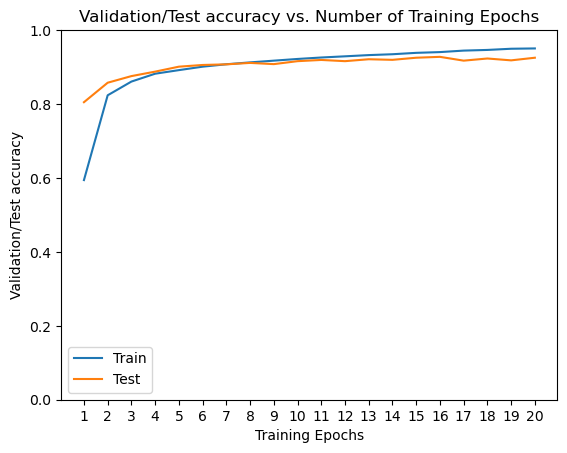

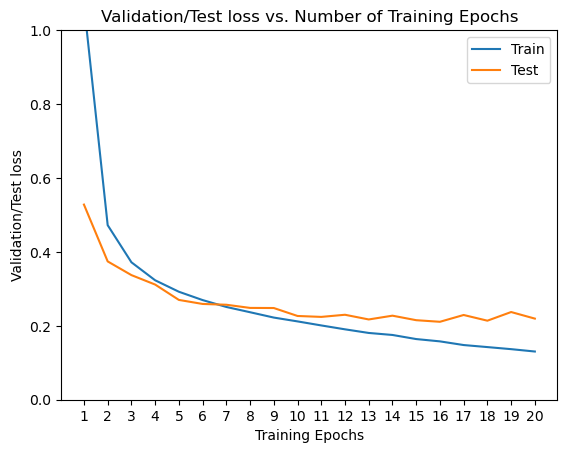

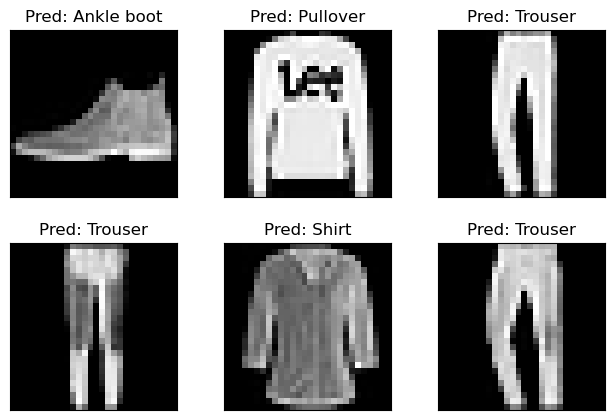

In [23]:
train_loader = DataLoader(dataset=train_set, shuffle=True, **loader_params)
test_loader = DataLoader(dataset=test_set, shuffle=False, **loader_params)

## model setup
model = AlexNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_acc_history = []
test_acc_history = []

train_loss_history = []
test_loss_history = []

best_acc = 0.0
since = time.time()

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # train
    training_loss, training_acc = training(model, train_loader, optimizer,criterion, device)
    train_loss_history.append(training_loss)
    train_acc_history.append(training_acc)

    # test
    test_loss, test_acc = test(model, test_loader, criterion, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    # overall best model
    if test_acc > best_acc:
        best_acc = test_acc
        #  best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(
    f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s'
)
print(f'Best val Acc: {best_acc:4f}')

# plot loss and accuracy curves
train_acc_history = [h.cpu().numpy() for h in train_acc_history]
test_acc_history = [h.cpu().numpy() for h in test_acc_history]

plot(train_acc_history, test_acc_history, 'accuracy', num_epochs,model.name())
plot(train_loss_history, test_loss_history, 'loss', num_epochs,model.name())

# plot examples
example_data, _ = next(iter(test_loader))
with torch.no_grad():
    output = model(example_data)

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Pred: {}".format(CATEGORIES[output.data.max(1, keepdim=True)[1][i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.savefig("alexnet.png")
    plt.show()

Epoch 0/19
----------
Training Batch:    0 of 938
Training Batch:   10 of 938
Training Batch:   20 of 938
Training Batch:   30 of 938
Training Batch:   40 of 938
Training Batch:   50 of 938
Training Batch:   60 of 938
Training Batch:   70 of 938
Training Batch:   80 of 938
Training Batch:   90 of 938
Training Batch:  100 of 938
Training Batch:  110 of 938
Training Batch:  120 of 938
Training Batch:  130 of 938
Training Batch:  140 of 938
Training Batch:  150 of 938
Training Batch:  160 of 938
Training Batch:  170 of 938
Training Batch:  180 of 938
Training Batch:  190 of 938
Training Batch:  200 of 938
Training Batch:  210 of 938
Training Batch:  220 of 938
Training Batch:  230 of 938
Training Batch:  240 of 938
Training Batch:  250 of 938
Training Batch:  260 of 938
Training Batch:  270 of 938
Training Batch:  280 of 938
Training Batch:  290 of 938
Training Batch:  300 of 938
Training Batch:  310 of 938
Training Batch:  320 of 938
Training Batch:  330 of 938
Training Batch:  340 of 93

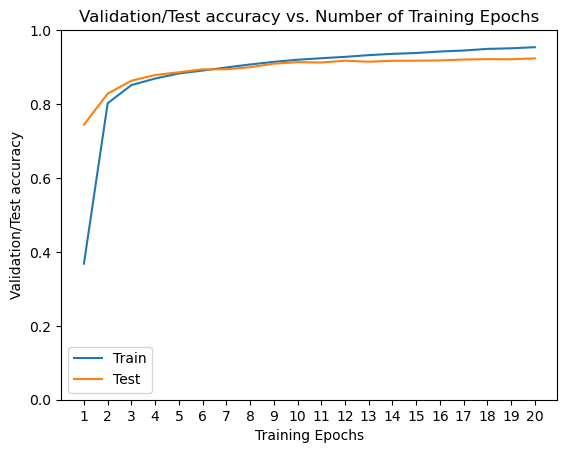

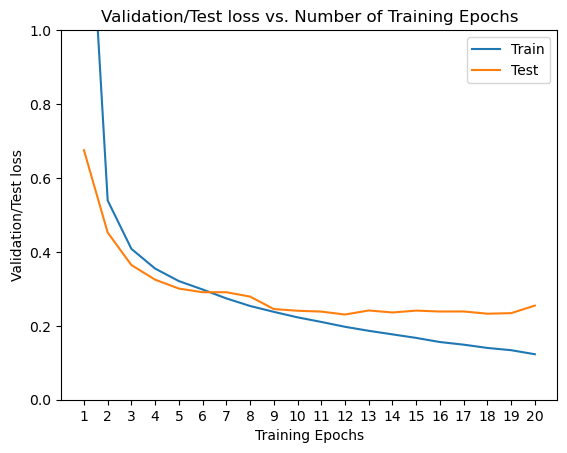

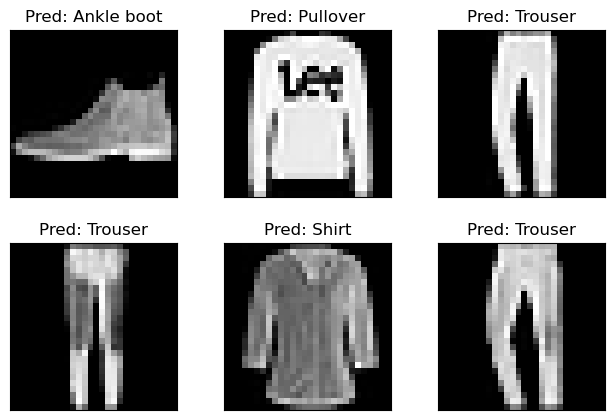

In [39]:
train_loader = DataLoader(dataset=train_set, shuffle=True, **loader_params)
test_loader = DataLoader(dataset=test_set, shuffle=False, **loader_params)

## model setup
model = VGG16().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_acc_history = []
test_acc_history = []

train_loss_history = []
test_loss_history = []

best_acc = 0.0
since = time.time()

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # train
    training_loss, training_acc = training(model, train_loader, optimizer,criterion, device)
    train_loss_history.append(training_loss)
    train_acc_history.append(training_acc)

    # test
    test_loss, test_acc = test(model, test_loader, criterion, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    # overall best model
    if test_acc > best_acc:
        best_acc = test_acc
        #  best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(
    f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s'
)
print(f'Best val Acc: {best_acc:4f}')

# plot loss and accuracy curves
train_acc_history = [h.cpu().numpy() for h in train_acc_history]
test_acc_history = [h.cpu().numpy() for h in test_acc_history]

plot(train_acc_history, test_acc_history, 'accuracy', num_epochs,model.name())
plot(train_loss_history, test_loss_history, 'loss', num_epochs,model.name())

# plot examples
example_data, _ = next(iter(test_loader))
with torch.no_grad():
    output = model(example_data)

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Pred: {}".format(CATEGORIES[output.data.max(1, keepdim=True)[1][i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.savefig("vgg16.png")
    plt.show()
